# Sheet 6

Leonard Benkendorff, Dorothea Schwärzel, Sebastian Preuß

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse
from sklearn.linear_model import Ridge, LinearRegression

## 1 Regularization and Bias
\begin{figure}[H]
\includegraphics[width=8cm]{ex1.jpg}
\end{figure}

## 2 Estimating Parameter Relevance

In [2]:
# load the data
with open('data/vostok.txt', 'r') as f:
    lines = f.readlines()
    
# remove header and split lines
lines = [l.split() for l in lines[2:]]

# filter out lines with missing data
lines = [l for l in lines if len(l) == 4]

# convert to float
lines = np.array(lines).astype(np.float32)
print(f'{lines.shape=}')

features = np.concatenate([lines[:, :1], lines[:, 2:]], axis=1).T
feature_names = 'age', 'CO₂', 'dust'
labels = lines[:, 1]
label_name = '∆T'

print(f'{features.shape=}, {labels.shape=}')

lines.shape=(3729, 4)
features.shape=(3, 3729), labels.shape=(3729,)


Sum of squared deviations: 6362.9375


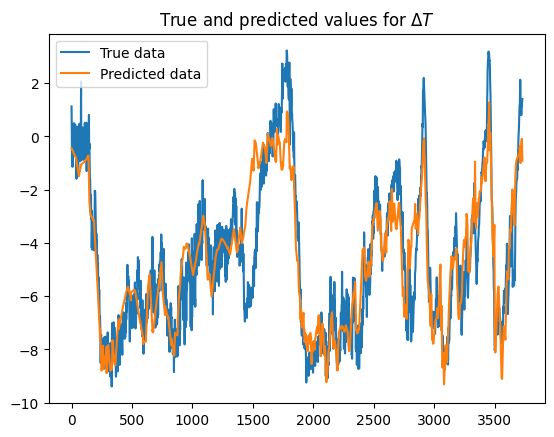

In [3]:
from sklearn.linear_model import LinearRegression

# TODO: fit the linear regressor and compute the sum of square deviations
lr = LinearRegression()
lr.fit(features.T, labels)

print('Sum of squared deviations:', np.sum((lr.predict(features.T)-labels)**2))

plt.plot(labels, label='True data')
plt.plot(lr.predict(features.T), label='Predicted data')
plt.legend(loc='best')
plt.title(r'True and predicted values for $\Delta T$')
plt.show()

Sum of squared deviations after shuffling age: 6796.764275972411
Sum of squared deviations after shuffling CO₂: 18962.56096840998
Sum of squared deviations after shuffling dust: 6565.202563606381


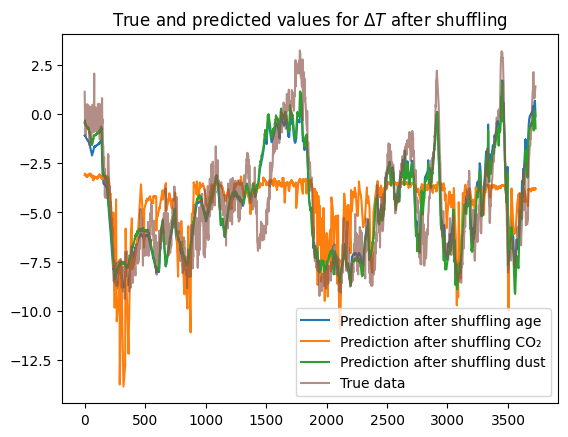

In [4]:
# TODO: for each feature, randomly permute it amongst the samples, 
#       refit the regressor and compte sum of squared deviations
for i in range(3):
    new_order = np.arange(features.shape[-1])
    np.random.shuffle(new_order)
    shuffled_features = np.zeros(features.shape)
    for j in range(3):
        if i == j:
            shuffled_features[i,:] = features[i,new_order]
        else:
            shuffled_features[j,:] = features[j,:]
        
    lr = LinearRegression()
    lr.fit(shuffled_features.T, labels)
    print(f'Sum of squared deviations after shuffling {feature_names[i]}:', np.sum((lr.predict(features.T)-labels)**2))
    plt.plot(lr.predict(shuffled_features.T), label=f'Prediction after shuffling {feature_names[i]}')
plt.plot(labels, label='True data', color='#8c564baa') # add some transparency
plt.legend(loc='best')
plt.title(r'True and predicted values for $\Delta T$ after shuffling')
plt.show()

**Which feature is most important and which is least relevant?**
The difference to the original sum of squared deviations is as follows:
\begin{align}
\Delta_\text{age}&=|6362.9375 - 6824.1124| &= 461.2\\
\Delta_{\text{CO}_2}&=|6362.9375 - 18944.9081|&= 12582.0\\
\Delta_\text{dust}&=|6362.9375 - 6537.4003| &= 174.5
\end{align}
(This may differ from the output above if the code is re-run, because `np.random.shuffle` returns a new, random, result every time).

We conclude: The feature $\text{CO}_2$ is the most important one, the feature dust is the least important one. This conclusion can (at least for $\text{CO}_2$) also be drawn from the visualisation we included.

## 3 $\sigma^2$-estimation and Heteroscedastic Noise

\begin{figure}[H]
\includegraphics[width=8cm]{cex3.jpg}
\end{figure}

Comparison to SSQ: In the lecture we derived the covariance of $\beta$ from the distribution of the variance of the original data. We did not find an expression for the likeliest variance $\sigma^2$.

## 4 Visualize Regularization Contours

In [5]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'{x.shape} {y.shape}')

(2, 100) (1, 100)


In [6]:
# TODO: create a grid of points in the parameter space
beta1 = np.linspace(-1,3,150)
beta2 = np.linspace(-1,3,150)
beta1,beta2 = np.meshgrid(beta1, beta2)

(a)

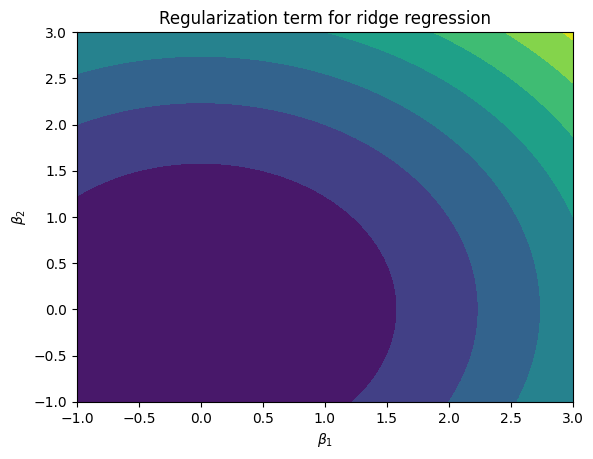

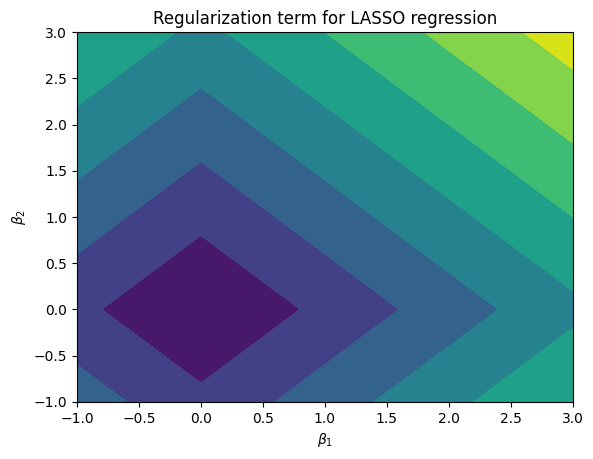

In [7]:
# TODO: make coutour plots for ridge and lasso regularization terms
def regulariz_ridge(beta1, beta2): # essentially the 2-norm
    return beta1*beta1 + beta2*beta2

def regulariz_lasso(beta1, beta2): # essentially the 1-norm
    return np.abs(beta1)+np.abs(beta2)
    
    
plt.title('Regularization term for ridge regression')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.contourf(beta1, beta2, regulariz_ridge(beta1,beta2))
plt.show()

plt.title('Regularization term for LASSO regression')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.contourf(beta1, beta2, regulariz_lasso(beta1,beta2))

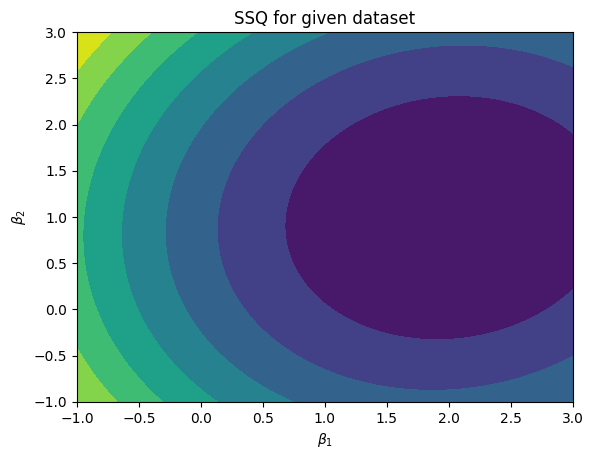

In [8]:
# TODO: for each combination of parameters, compute the sum of squared deviations.
#       do not use loops, but numpy broadcasting!
# TODO: make a coutour plot for sum of squared deviations

# the stuff below uses loops, can't figure out how to do it with broadcasting :/
def SSQ(beta1,beta2,features, labels):
    z = np.zeros((beta1.shape[0], beta2.shape[0]))
    for i,b1 in enumerate(beta1):
        for j,b2 in enumerate(beta2):
            beta = [b1, b2]
            z[i,j] = np.sum((beta @ features - labels)**2)
    return z

#print(np.outer(beta1,x[0,:]).shape, beta1.shape, x[0,:].shape)
#print(beta1)
#print(beta1.shape, beta2.shape, z.shape)
beta1 = np.linspace(-1,3,150)
beta2 = np.linspace(-1,3,150)
z = SSQ(beta1, beta2, x, y)

plt.contourf(beta1,beta2,z)
plt.title('SSQ for given dataset')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.show()

(c)

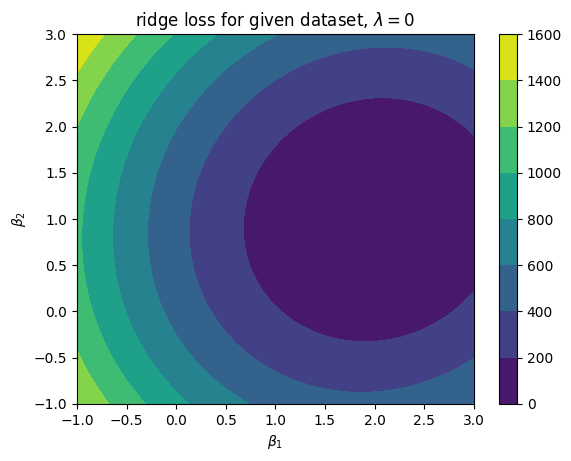

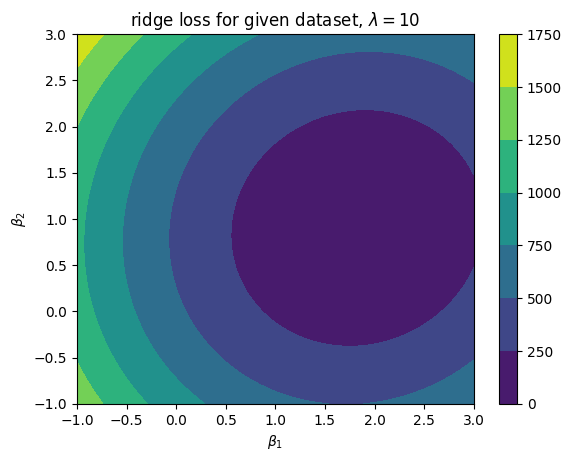

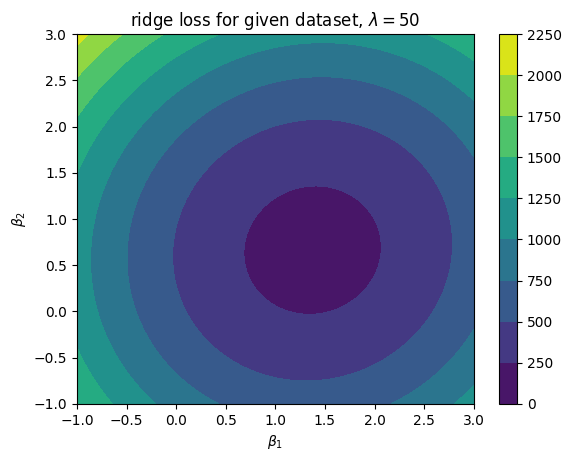

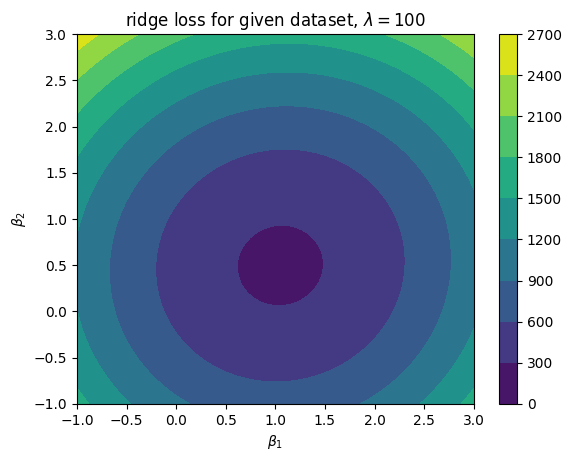

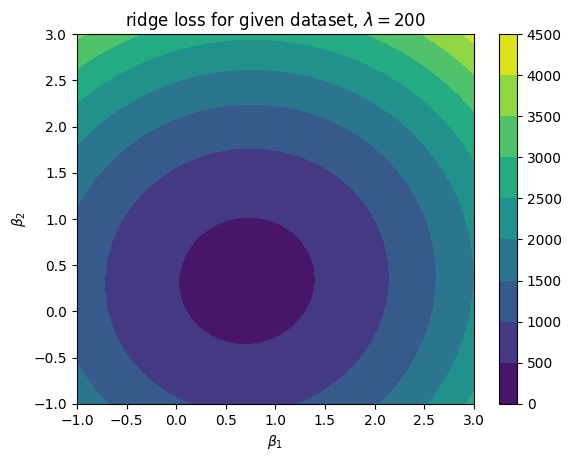

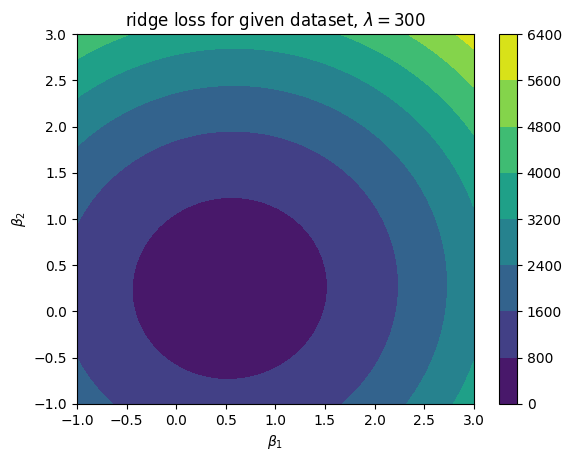

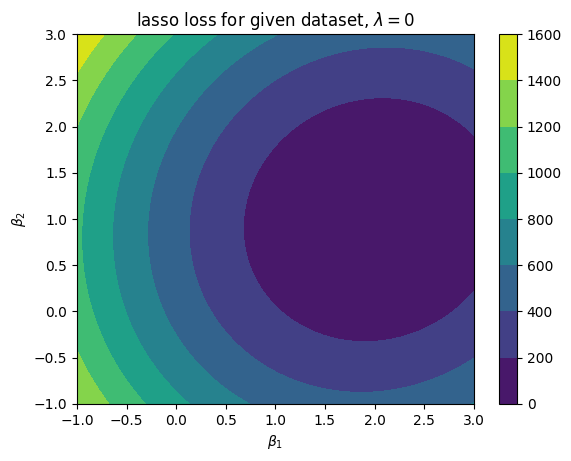

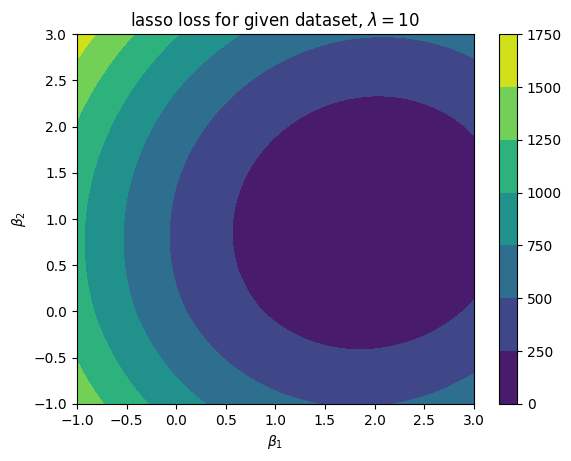

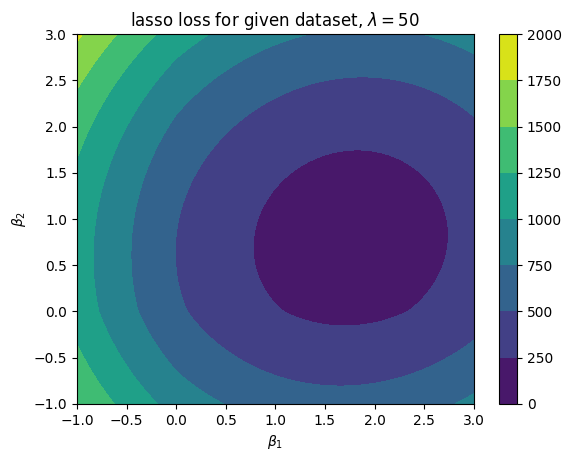

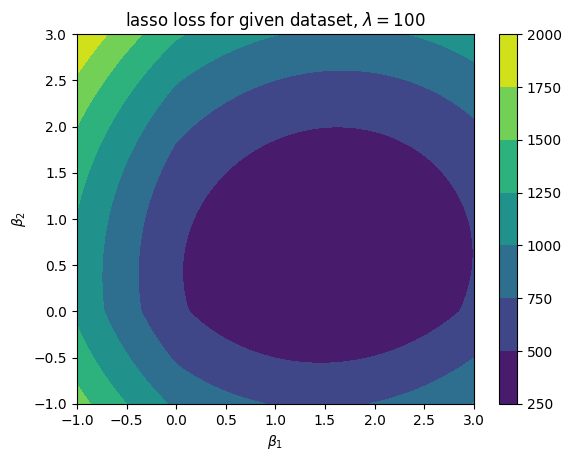

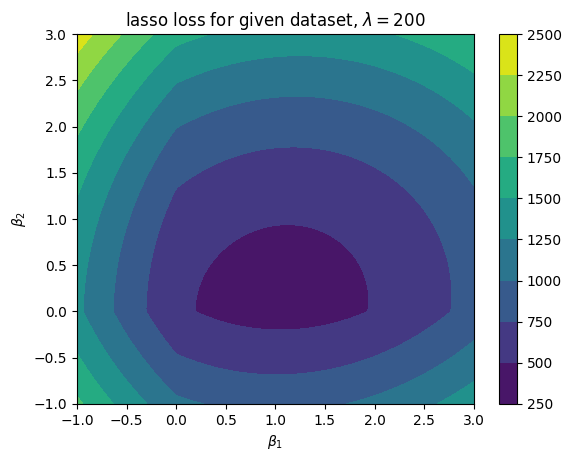

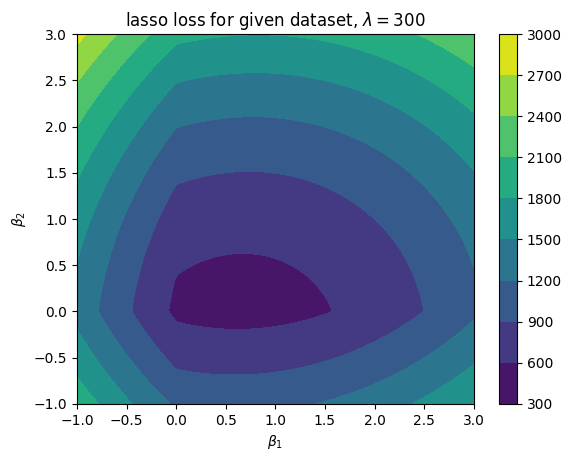

In [9]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
def loss(beta1, beta2, lam, features, labels, method='ridge'):
    mbeta1, mbeta2 = np.meshgrid(beta1, beta2) # use meshgrid-functions for regulariz.terms
    regulariz = np.zeros((beta1.shape[0], beta2.shape[0]))
    if method=='ridge':
        regulariz = regulariz_ridge(mbeta1, mbeta2)
    elif method=='lasso':
        regulariz = regulariz_lasso(mbeta1, mbeta2)
    else:
        raise NameError(f'Name {method} is not a specified regularization method :(')
    return SSQ(beta1, beta2, features, labels) + lam*regulariz

for meth in ['ridge', 'lasso']: # lets _speed_ this up with some _meth_s
    for lam in [0, 10, 50, 100, 200, 300]:
        lss = loss(beta1, beta2, lam, x, y, method=meth)
        plt.contourf(beta1, beta2, lss)
        plt.colorbar()
        plt.title(f'{meth} loss for given dataset, $\lambda={lam}$')
        plt.xlabel(r'$\beta_1$')
        plt.ylabel(r'$\beta_2$')
        plt.show()

Discussion: We observe the following:

 - For higher values of $\lambda$, we see that the overall magnitude of losses increases (obviously), hence the gradient of the loss surfaces is increased as well.
 - For higher values of $\lambda$, the shape of the loss surface stays roughly the same for ridge regression: It is transformed from a elliptical shape to a more circular shape, i.e. the eccentricity of the contour lines shrinks.
 - For ridge regression, higher values of $\lambda$ distort the contour lines towards a rhombus: The loss surfaces are just a superposition of the (elliptical) SSQ and the (rhomboidal) lasso loss.

## 5 CT reconstruction

set up design matrix (run this once to save to disk)

In [10]:
# create design matrix
# don't change any of this, just run it once to create and save the design matrix
import os

if not os.path.exists('data/design_matrix.npy'):
    res = (99, 117)
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 #np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    n_parallel_rays = 70 
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_ray_angles = 30
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles
    
    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    def rot_mat(angle):
        c, s = np.cos(angle), np.sin(angle)
        return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    kernel = lambda x: np.exp(-x**2/sigma**2/2)

    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

(a)

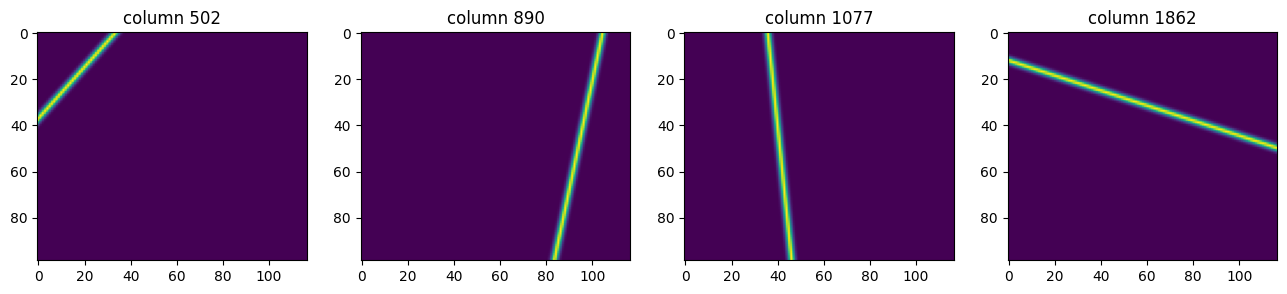

In [11]:
design_matrix = np.load('data/design_matrix.npy')
res = (99, 117)

# TODO: visualize four random columns as images, using an image shape of (99, 117)
img_shape = (99, 117)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in zip(np.random.choice(np.arange(design_matrix.shape[1]), 4), axs):
    ax.imshow(design_matrix[:, i].reshape(*res));
    ax.set_title(f'column {i}')

Interpretation of a column of $X$:
Every column of $X$ describes the axis along which the detectors are positioned relative to the object to be reconstructed. Weighing the original object with a column of $X$ gives the part of the object which can be projected onto the detector, the integral over this then gives the detector signal strength.

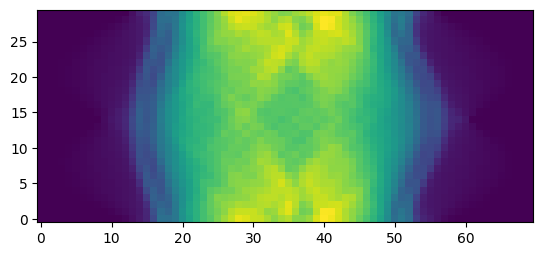

In [12]:
sino = np.load('data/sino.npy')

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower')
plt.show();

(b)

In [13]:
# TODO: solve the reconstruction with linear regression and visualize the result
X = design_matrix
beta = np.linalg.inv(X @ X.T) @ X @ sino.T

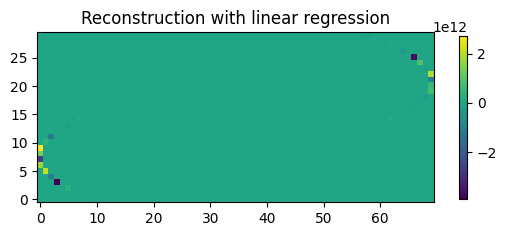

In [14]:
reconst = beta.T @ X
plt.imshow(reconst.reshape(n_angles, n_parallel_rays), origin='lower')
plt.colorbar(shrink=.44)
plt.title('Reconstruction with linear regression')
plt.show()

In [15]:
# TODO: solve the reconstruction with ridge regression and visualize the result
# Optional: try out different regularization strengths and oberve the influence
X = design_matrix
#beta_r = np.linalg.inv(X @ X.T + lam*np.identity(X.shape[0])) @ X @ sino.T

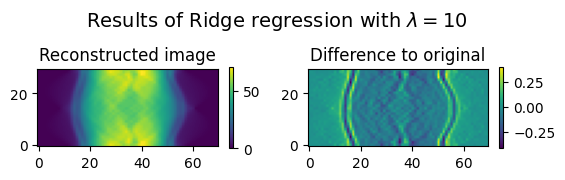

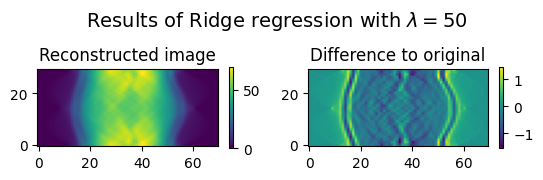

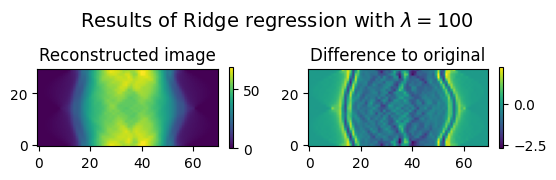

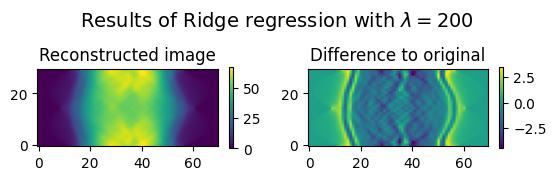

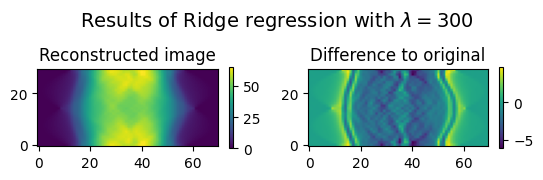

In [16]:
for lam in [10, 50, 100, 200, 300]:
    beta_r = np.linalg.inv(X @ X.T + lam*np.identity(X.shape[0])) @ X @ sino.T
    reconst = beta_r.T @ X
    plt.subplot(1,2,1)
    plt.title('Reconstructed image')
    plt.imshow(reconst.reshape(n_angles, n_parallel_rays), origin='lower')
    plt.colorbar(shrink=0.22)
    #plt.show()
    plt.subplot(1,2,2)
    plt.title('Difference to original')
    plt.imshow((reconst-sino).reshape(n_angles, n_parallel_rays), origin='lower')
    plt.colorbar(shrink=0.22)
    plt.suptitle(f"Results of Ridge regression with $\lambda={lam}$", y=0.7, fontsize=14)
    plt.show()

We observe that:

 - The plain Linear regression fails phenomenally at the task of reconstruction the image, because of the very inaccurate matrix inversion
 - For all values of $\lambda\in\{10,50,100,200,300\}$, the ridge regression give optically fine results, for the smallest value of $\lambda=10$, we get the least deviation from the original image.
 - The shape of the difference does not vary by a lot, only its magnitude changes meaningfully with $\lambda$